<a href="https://colab.research.google.com/github/KJM42/Jack_ML/blob/master/Copy_of_04_illum_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lytro Illum Demo 

This is a notebook recipe showing a sequence of steps necessary to read, calibrate and decompose a Lytro Illum photograph into so-called Sub-Aperture Images (SAIs) using **[PlenoptiCam](https://github.com/hahnec/plenopticam)**. SAIs correspond to perspective views in a light-field and can be thought of as viewpoint images captured by an array of cameras with consistent spacing. Because plenoptic cameras do not inherently feature this representation, the herein demonstrated decomposition is a crucial task in light-field imaging. 

<div class="alert alert-block alert-warning"><b>Note:</b> Due to the extensive memory requirements posed by the Illum files, this notebook yet only runs through on <a href="https://colab.research.google.com/github/hahnec/plenopticam/blob/develop/examples/04_illum_demo.ipynb" title="GoogleColab">GoogleColab</a>, which can be opened by clicking the badge below. <br>
<br>
<a href="https://colab.research.google.com/github/hahnec/plenopticam/blob/develop/examples/04_illum_demo.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

## Package and import prerequisites

In [ ]:
import sys
print('Python v'+sys.version+'\n')

try:
    import plenopticam as pcam
except ImportError:
    !pip install 'plenopticam>=0.7.0'
    import plenopticam as pcam
print('PlenoptiCam v'+pcam.__version__+'\n')

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib --upgrade
    import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

Python v3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]

PlenoptiCam v0.9.3



# New section

## Image data acquisition

Available plenoptic photographs can be downloaded to the current folder ('./data') using the featured `DataDownloader` class, which is also used for extracting archived files. 

In [ ]:
loader = pcam.misc.DataDownloader()
loader.download_data(loader.host_eu_url, fp='./data')
loader.extract_archive(archive_fn='./data/illum_test_data.zip', fname_list='lfr')

 Progress: Finished 


 Finished download of illum_test_data.zip
Extracted file caldata-B5144402350.tar
Extracted file gradient_rose_close.lfr
Extracted file gradient_rose_far.lfr


## Configuration of *PlenoptiCam*

Before running the light-field decomposition, file paths and basic calibration settings need to be set, using the `PlenopticamConfig` class as follows

In [ ]:
# instantiate config object and set image file paths and options
cfg = pcam.cfg.PlenopticamConfig()
cfg.default_values()
cfg.params[cfg.lfp_path] = './data/gradient_rose_close.lfr'
cfg.params[cfg.cal_path] = './data/caldata-B5144402350.tar'
cfg.params[cfg.opt_cali] = True
cfg.params[cfg.ptc_leng] = 13
cfg.params[cfg.cal_meth] = pcam.cfg.constants.CALI_METH[3]

# instantiate status object for progress
sta = pcam.misc.PlenopticamStatus()

## Reading a Lytro photograph

Loading and decoding a raw Illum image is required on a binary level prior to calibration as the file's header payload contains metadata used in the file selection of a respective white calibration image.

In [ ]:
reader = pcam.lfp_reader.LfpReader(cfg, sta)
reader.main()
lfp_img = reader.lfp_img


 Save raw image
 Progress: Finished 



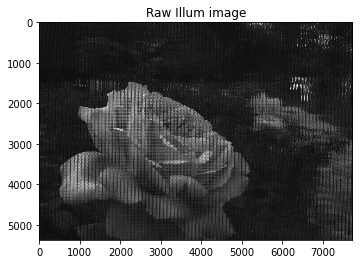

FileNotFoundError: ignored

In [ ]:
plt.figure()
plt.imshow(lfp_img, cmap='gray', interpolation='none')
plt.grid(False)
plt.title('Raw Illum image')
plt.show()

#fig = plt.figure(4)
#fig.set_size_inches(80,60)
#plt.title('Raw Lightfield Image (~intensity)',color = 'black',size=16)
#plt.imshow(lfp_img, cmap='gray',interpolation='none')
#plt.colorbar(shrink=1, pad=0.04)
#plt.clim(0,200)

import numpy as np

np.save(r'content/data/illum_test_data.zip/kevin_test1.npy',lfp_img,allow_pickle=True)

Lytro's cameras come with a zoom lens whose setting affects centroid positions. Therefore it is important to choose a white image from the _caldata-*.zip_ archive that corresponds to the same optical setting the loaded Illum image was taken with. This task is covered by the `CaliFinder` class which is dedicated to Lytro cameras only and used hereafter.

In [ ]:
cal_finder = pcam.lfp_calibrator.CaliFinder(cfg, sta)
ret = cal_finder.main()
wht_img = cal_finder.wht_bay

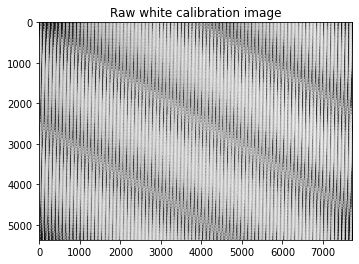

In [ ]:
plt.figure()
plt.imshow(wht_img, cmap='gray', interpolation='none')
plt.grid(False)
plt.title('Raw white calibration image')
plt.show()

Now the image data is read and stored in the `lfp_img` and `wht_img` variables.

## Micro image calibration

Once the white image is present, localization of micro image centroids $\mathbf{c}_{j,h}$ is conducted with the `LfpCalibrator` class at an abstract level. Results can be inspected in the plots below.

In [ ]:
cal_obj = pcam.lfp_calibrator.LfpCalibrator(wht_img, cfg, sta)
ret = cal_obj.main()
cfg = cal_obj.cfg


 Debayering
 Progress: Finished 


 Estimate micro image size
 Progress: Finished 


 Compute LoG
 Progress: Finished 


 Select maxima
 Progress: Finished 


 Refine micro image centers
 Progress: Finished 


 Sort micro image centers
 Progress: Finished 


 Grid fitting
 Progress: Finished 


 Save calibration data
 Progress: Finished 



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


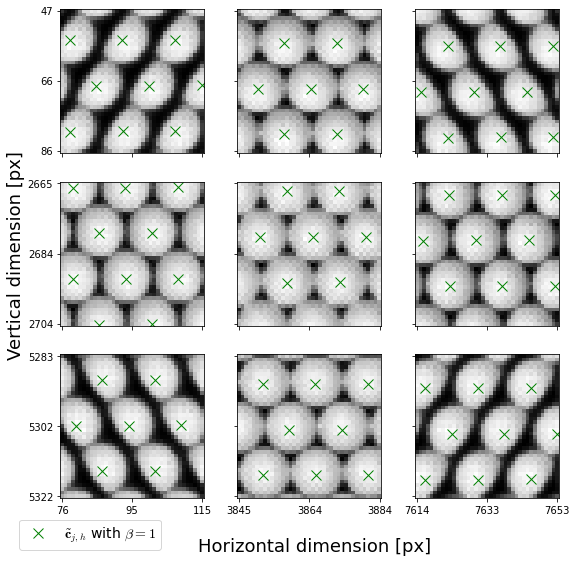

In [ ]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['pdf.fonttype'] = 42

y_coords = [row[0] for row in cfg.calibs[cfg.mic_list]]
x_coords = [row[1] for row in cfg.calibs[cfg.mic_list]]

s = 3
h, w, c = wht_img.shape if len(wht_img.shape) == 3 else wht_img.shape + (1,)
hp, wp = [39]*2
fig, axs = plt.subplots(s, s, facecolor='w', edgecolor='k', figsize=(9, 9))
markers = ['r.', 'b+', 'gx']
labels = [r'$\bar{\mathbf{c}}_{j,h}$', 
          r'$\tilde{\mathbf{c}}_{j,h}$ with $\beta=0$', 
          r'$\tilde{\mathbf{c}}_{j,h}$ with $\beta=1$']
m = 2

for i in range(s):
    for j in range(s):
        # plot cropped image part
        k = h//2 + (i-s//2) * int(h/2.05) - hp // 2
        l = w//2 + (j-s//2) * int(w/2.05) - wp // 2
        axs[i, j].imshow(wht_img[k:k+hp, l:l+wp, ...], cmap='gray')

        # plot centroids in cropped area
        coords_crop = [(y, x) for y, x in zip(y_coords, x_coords) 
                       if k <= y <= k+hp-.5 and l <= x <= l+wp-.5]
        y_centroids = [row[0] - k for row in coords_crop]
        x_centroids = [row[1] - l for row in coords_crop]
        axs[i, j].plot(x_centroids, y_centroids, markers[m], 
                       markersize=10, label=labels[m])
        axs[i, j].grid(False)

        if j == 0 or i == s-1:
            if j == 0 and i == s-1:
                axs[i, j].tick_params(top=False, bottom=True, left=True, right=False,
                                      labelleft=True, labelbottom=True)
                axs[i, j].set_yticklabels([str(k), str(k+hp//2), str(k+hp)])
                axs[i, j].set_xticklabels([str(l), str(l+wp//2), str(l+wp)])
            elif j == 0:
                axs[i, j].tick_params(top=False, bottom=True, left=True, right=False,
                                      labelleft=True, labelbottom=False)
                axs[i, j].set_yticklabels([str(k), str(k+hp//2), str(k+hp)])
            elif i == s-1:
                axs[i, j].tick_params(top=False, bottom=True, left=True, right=False,
                                      labelleft=False, labelbottom=True)
                axs[i, j].set_xticklabels([str(l), str(l+wp//2), str(l+wp)])

        else:
            axs[i, j].tick_params(top=False, bottom=True, left=True, right=False,
                                  labelleft=False, labelbottom=False)

        axs[i, j].set_yticks(range(0, hp+1, hp//2))
        axs[i, j].set_xticks(range(0, wp+1, wp//2))

plt.legend(loc='upper left', bbox_to_anchor=(-2.8, -.1), fancybox=True, fontsize=14)
# set common labels
fig.text(0.52, 0.05, 'Horizontal dimension [px]', ha='center', va='center', fontsize=18)
fig.text(0.06, 0.5, 'Vertical dimension [px]', ha='center', va='center', rotation='vertical', fontsize=18)

fig.tight_layout()
plt.savefig('centroid_LMA_fits+regular_div.pdf', bbox_inches="tight")
plt.show()

## Micro image alignment

With the centroids estimated, the original `lfp_img` is rectified by means of the `LfpAligner` class such that Lytro's hexagonally ordered micro images are rearranged to a rectangular grid exposing consistent resolution.

In [ ]:
ret = cfg.load_cal_data()
aligner = pcam.lfp_aligner.LfpAligner(lfp_img, cfg, sta, wht_img)
ret = aligner.main()
lfp_img_align = aligner.lfp_img


 Hot pixel detection
 Progress: Finished 


 Debayering
 Progress: Finished 


 Light-field alignment
 Progress: Finished 


 Save aligned light-field

 Potential data loss as directory already exists.
 Progress: Finished 



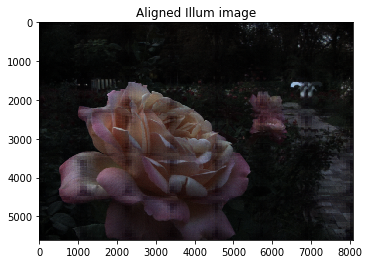

In [ ]:
from os.path import join, basename
import pickle

with open(join(cfg.exp_path, 'lfp_img_align.pkl'), 'rb') as f:
    lfp_img_align = pickle.load(f)
    
plt.figure()
plt.imshow(lfp_img_align/lfp_img_align.max(), interpolation='none')
plt.grid(False)
plt.title('Aligned Illum image')
plt.show()

try:
    from plenopticam.lfp_reader import LfpDecoder
    # try to load json file (if present)
    json_dict = cfg.load_json(cfg.exp_path, basename(cfg.exp_path)+'.json')
    cfg.lfpimg = LfpDecoder.filter_lfp_json(json_dict, cfg.lfpimg)
except FileNotFoundError:
    pass

## Sub-Aperture Image (SAI) extraction

Rendering perspective views, known as SAIs, from an aligned light-field image `lfp_img_align` is accomplished by a `LfpExtractor` object. The resulting `vp_img_arr` is displayed in various ways further below.

In [ ]:
extractor = pcam.lfp_extractor.LfpExtractor(lfp_img_align, cfg, sta)
ret = extractor.main()
vp_img_arr = extractor.vp_img_arr


 Viewpoint composition
 Progress: Finished 


 Color equalization
 Progress: Finished 


 Write viewpoint images
 Progress: Finished 


 Compute depth map
 Progress: Finished 


 Write depth data
 Progress: Finished 



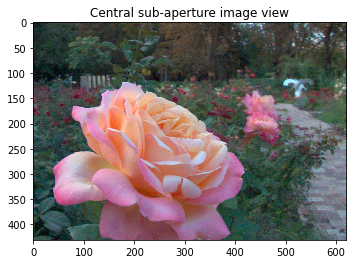

In [ ]:
view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
vp_view = view_obj.central_view

plt.figure()
plt.imshow(vp_view/vp_view.max(), interpolation='none')
plt.grid(False)
plt.title('Central sub-aperture image view')
plt.show()

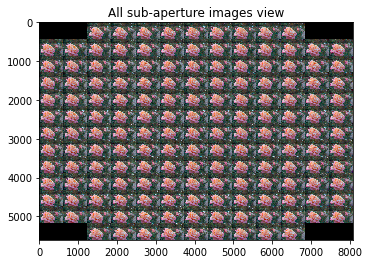

In [ ]:
view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
vp_stack = view_obj.views_stacked_img

plt.figure()
plt.imshow(vp_stack/vp_stack.max(), interpolation='none')
plt.grid(False)
plt.title('All sub-aperture images view')
plt.show()

In [ ]:
view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
vp_arr = view_obj.reorder_vp_arr(pattern='circle', lf_radius=3)

fig, ax = plt.subplots()
ax.set_title('View animation')
l = ax.imshow(vp_arr[0])
animate = lambda i: l.set_data(vp_arr[i])
anim = animation.FuncAnimation(fig, animate, frames=len(vp_arr), interval=50)
plt.close() # get rid of initial figure

HTML(anim.to_jshtml())

## Computational change of focus

The light-field's well known synthetic focus capability is managed by the `LfpRefocuser` class with exemplary parameter setting $a=[-1,2]$ in the `cfg.params` dictionary and key `cfg.ran_refo` controling the refocused range.

In [ ]:
# set refocus range $a$
cfg.params[cfg.ran_refo] = [-1, 2]
cfg.params[cfg.opt_prnt] = False
# use non-gamma corrected viewpoint array
refocuser = pcam.lfp_refocuser.LfpRefocuser(vp_img_arr=extractor.vp_img_linear, cfg=cfg)
refocuser.main()
refo_stack = refocuser.refo_stack

fig, ax = plt.subplots()
ax.set_title('Refocusing animation')
l = ax.imshow(refo_stack[0])
animate = lambda i: l.set_data(refo_stack[i])
anim = animation.FuncAnimation(fig, animate, frames=len(refo_stack), interval=1000)
plt.close() # get rid of initial figure

HTML(anim.to_jshtml())

## Depth map extraction

Depth inference from light-fields is a capability *PlenoptiCam* offers by means of the `LfpDepth` class using the parameter key `cfg.opt_dpth` in the `cfg.params` dictionary.

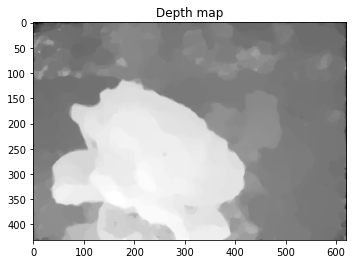

In [ ]:
# compute and write depth data from epipolar analysis
if cfg.params[cfg.opt_dpth]:
    obj = pcam.lfp_extractor.LfpDepth(vp_img_arr=vp_img_arr, cfg=cfg, sta=sta)
    obj.main()
    depth_map = obj.depth_map

# plot depth map in 2-D
fig, ax = plt.subplots()
ax.set_title('Depth map')
ax.imshow(depth_map, cmap='gray')
plt.show()

# plot depth map in 3-D
fig, ax = plt.figure(figsize=(5, 5)), plt.axes(projection='3d')
ax.set_facecolor('#ffffff') #148ec8
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = obj.plot_point_cloud(rgb_img=vp_view, down_scale=2, ax=ax)
plt.close() # get rid of initial figure
animate = lambda i: ax.view_init(60, 60+i*20)
anim = animation.FuncAnimation(fig, animate, frames=18, interval=100, repeat=True)
HTML(anim.to_jshtml())

In [ ]:
try:
    anim.save('depth_anim.gif', writer='imagemagick', fps=10)
except TypeError:
    anim.save('depth_anim.gif', writer='pillow', fps=10)